In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ptycho_lebeau.raw import load_4d, save_4d
from fun import *
import os
%matplotlib widget

/Users/menglin/PycharmProjects/PySTEM/MIT/TiltMapping/fun.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [176]:
os.chdir('/Users/menglin/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/MIT_Data/PMN/Experiments/250210_PMNPT/NBED')
data4d = load_4d('scan_x38_y38.raw')[:, :, 2:-2, 2:-2]
i=0
j=0

## 1. Mannual Processing a single pattern 

### 1.1. Creat a mask only including kichuchi bands

In [177]:
rows, cols = data4d.shape[-2:]
center = (cols // 2, rows // 2)
dp = np.mean(data4d[30:40,80:90], axis=(0, 1))
dp = data4d[i, j]

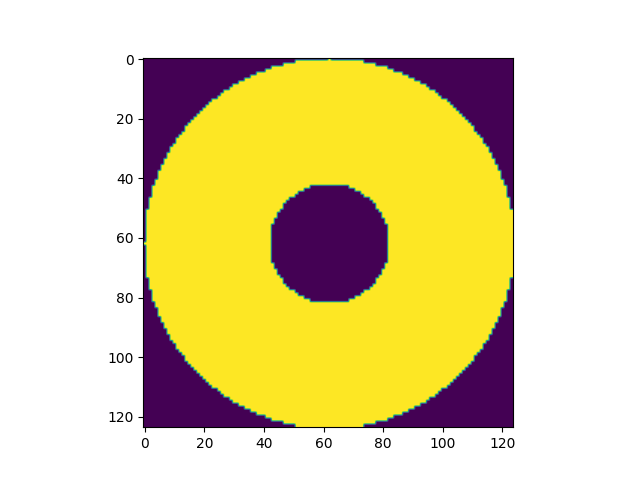

In [178]:
inner_radius = 20
mask, radius = annular_mask(dp, inner_radius=inner_radius, center=center)
plt.figure()
plt.imshow(mask)

### 1.2. Normalize kikuchi patterns radially

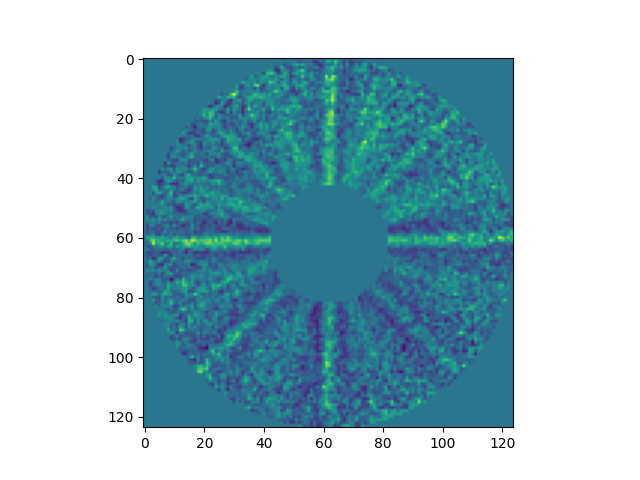

In [179]:
norm_data4d = normalize_azimuthal_scan(dp, mask, center=center)
plt.figure()
plt.imshow(norm_data4d)

### 1.3. Extract azimuth line profile of the masked pattern and apply a high pass filter to remove DC singals from tilting

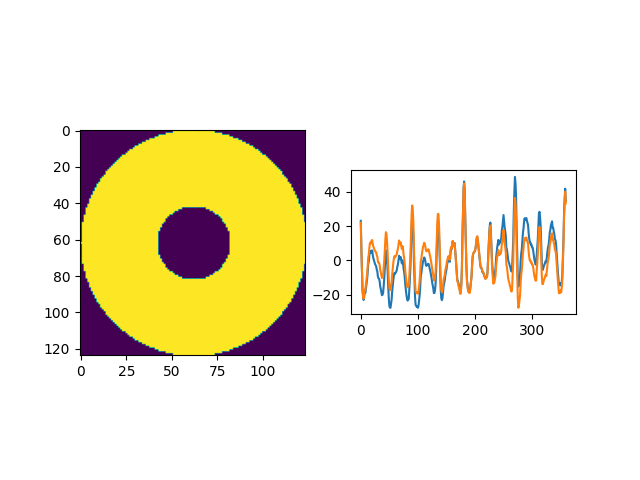

In [180]:
azimuthal_bin_width = 5
hp_cutoff=5

lp, lp_mask = extract_azimuthal_profile(norm_data4d, mask, azimuthal_bin_width=azimuthal_bin_width, center=center)
fig, ax = plt.subplots(1, 2)
filter_lp = high_pass_filter_azimuthal(lp, cutoff=hp_cutoff)
ax[0].imshow(np.mean(lp_mask, axis=2))
ax[1].plot(lp)
ax[1].plot(filter_lp)
ax[1].set_aspect(3)


### 1.4. Detect peaks that corresponds to kikuchi bands

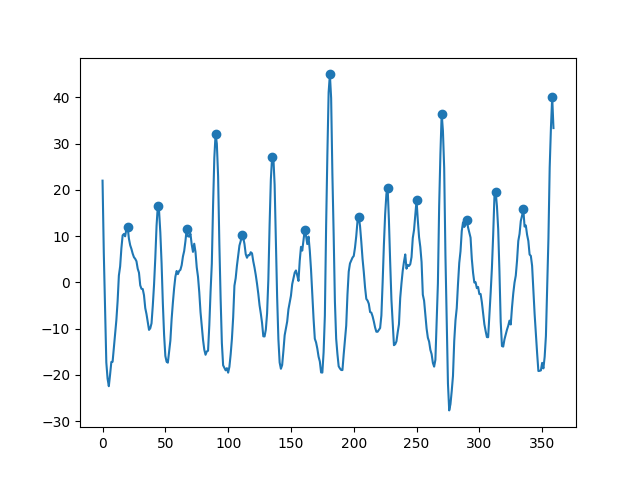

In [181]:
min_prominence = 10
min_distance=15

kikuchi_peaks = detect_kikuchi_peaks(filter_lp, min_prominence=min_prominence, min_distance=min_distance)
plt.figure()
plt.plot(filter_lp)
plt.scatter(kikuchi_peaks[:, 0], kikuchi_peaks[:, 1], )

(<Figure size 640x480 with 1 Axes>, <Axes: >)

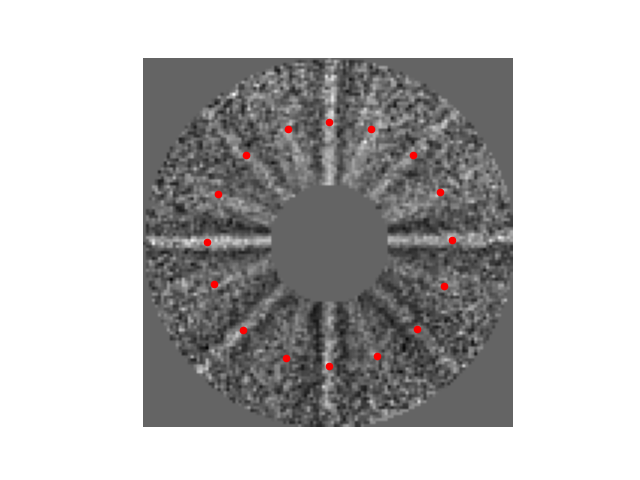

In [182]:
plot_peaks_on_image(norm_data4d, center=center, radius=radius, peaks_angles=kikuchi_peaks[:, 0])

### 1.5. Find the optimal crossing with lowest deviation by selecting expected number of peaks from all the detected peak 

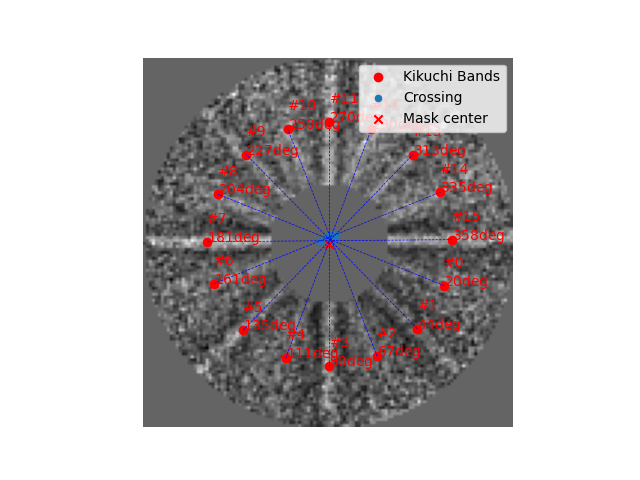

In [183]:
stability_ratio = 0.8

n_bands=8
max_samples=10000

res = find_optimal_crossings(kikuchi_peaks, n=n_bands, center=center, radius=radius, max_samples=max_samples, stability_ratio=stability_ratio)
plot_optimal_crossing(dp, inner_radius=inner_radius, optimal_crossing=res)

### 1.6. Check if the current mask center is within the crossing range, if not, iterate mannually with the new center

In [184]:
converged, center = point_in_hull(center, res['hull'])
print(converged, center)

False [62.19026882 60.24201249]


## 2. Autmatic processing of a single pattern

In [ ]:
dp = data4d[9, 10]
res = analyze_kikuchi_pattern(dp, initial_center=None, inner_radius=inner_radius, 
                             azimuthal_bin_width=azimuthal_bin_width, n_bands=n_bands, hp_cutoff=hp_cutoff,
                             min_prominence=min_prominence, min_distance=min_distance, stability_ratio=stability_ratio,
                             max_iterations=3, tolerance=0.5, max_samples=max_samples)

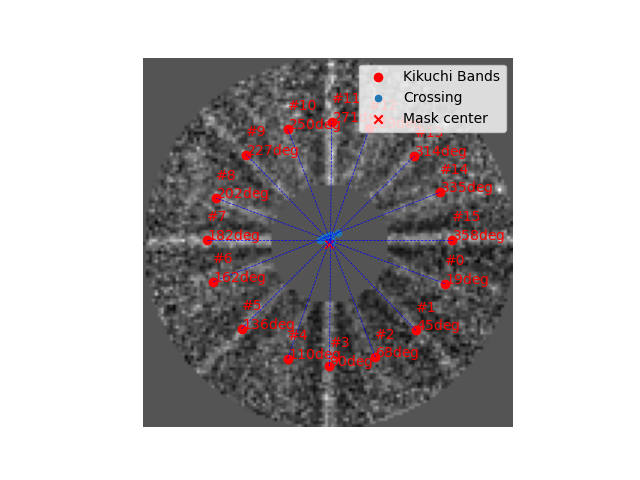

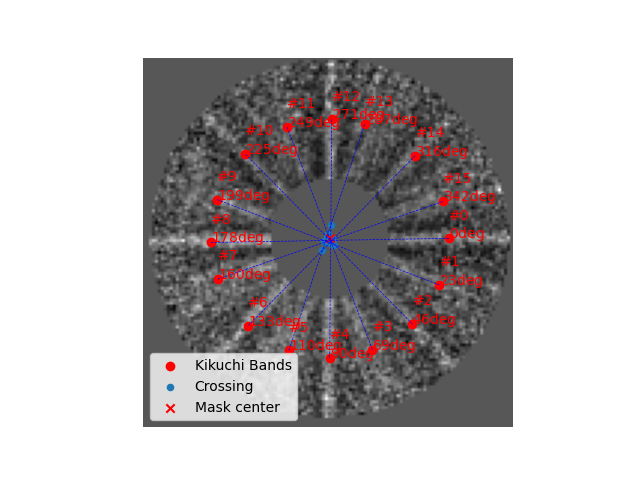

In [205]:
for iter in res['iterations']:
    plot_optimal_crossing(dp, iter, inner_radius=inner_radius)

## 3. Automatic processing of 4D data

In [190]:
# os.chdir('/Users/menglin/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/MIT_Data/PMN/Experiments/250210_PMNPT/NBED/')

# folders = ['0_385_327', '3_384_326', '9_384_326', '27_383_326',  '-27_311_281']

# raw = []
# for folder in folders:
#     data4d = np.array(load_4d(f'{folder}/scan_x128_y128.raw'))
#     data4d = replace_nans_with_average(data4d)
#     data4d = apply_spatial_local_averaging(data4d, 3)
#     raw.append(data4d)
# data4d = np.concatenate(raw, axis=0)

# os.chdir('/Users/menglin/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/MIT_Data/PMN/Experiments/250210_PMNPT/NBED/')

data4d = load_4d('scan_x38_y38.raw')[:, :, 2:-2, 2:-2]

In [191]:
results = analyze_4d_kikuchi_patterns(
    data4d, n_jobs=0, initial_center=None, inner_radius=inner_radius, 
    azimuthal_bin_width=azimuthal_bin_width, n_bands=n_bands, hp_cutoff=hp_cutoff,
    min_prominence=min_prominence, min_distance=min_distance, stability_ratio=stability_ratio,
    max_iterations=10, tolerance=2.0, max_samples=max_samples
)

save_dict_array(dict_array=results, ) #discard_keys=['crossings', 'hull', 'radius', 'iterations', 'n_iterations'])

Processing Patterns:   0%|          | 0/1444 [00:00<?, ?pattern/s]

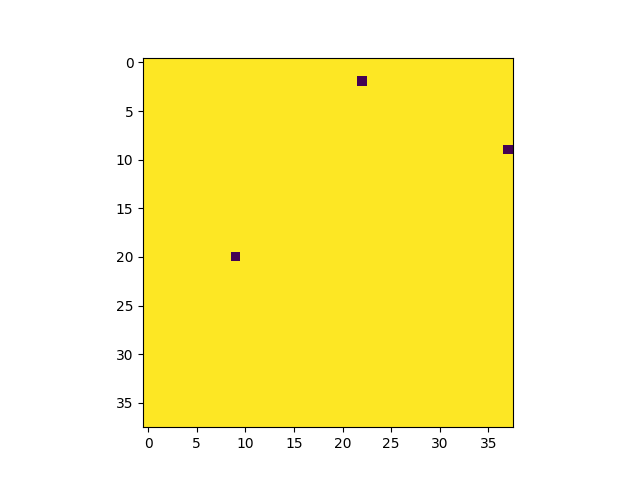

In [192]:
zero_beam = (62.7615, 63.515,)
pixel_size = 1.959
converged_values = np.array([[res["converged"] for res in row] for row in results], dtype=bool)
tilt_center = np.rollaxis(np.array([[res["final_center"] for res in row] for row in results], dtype=float), -1)
tilt_center[:, ~converged_values] = np.nan

plt.figure()
plt.imshow(converged_values)

In [206]:
k_masks, masked_k_data = create_peak_masks_and_data(results, data4d, peak_ids=[3, 7, 11, 15], inner_radius=20, outer_radius=55, angular_range=5)
# save_4d(np.sum(masked_k_data, axis=(2)), name='kikuchi_x128_y128.raw')
k_com = compute_centers_of_mass(np.sum(masked_k_data, axis=(2)))

/Users/menglin/miniforge3/envs/pySTEM/lib/python3.10/site-packages/scipy/ndimage/_measurements.py:1541: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


In [208]:
diff = k_com-np.nanmean(k_com, axis=(1, 2)).reshape(2,1,1)

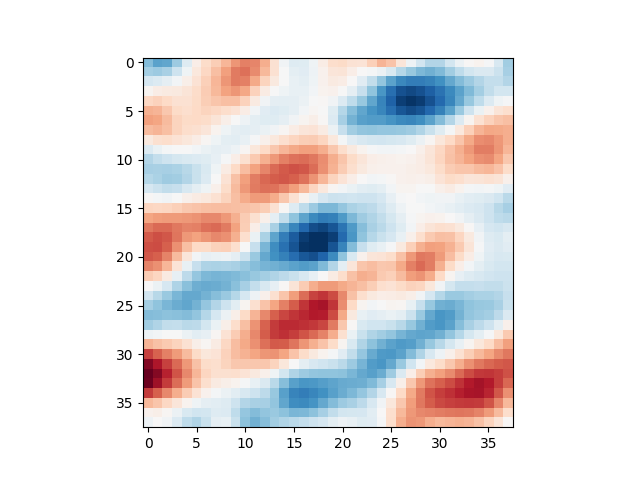

In [209]:
diff = np.nan_to_num(diff, 0)[:,  -128:, :128,]
from skimage.filters import gaussian, difference_of_gaussians
DOG_x = difference_of_gaussians(diff[0], 1.5, 10)
DOG_y = difference_of_gaussians(diff[1], 1.5, 10)

plt.figure()
plt.imshow(DOG_y, cmap='RdBu',  vmin=-0.5,vmax=0.5)

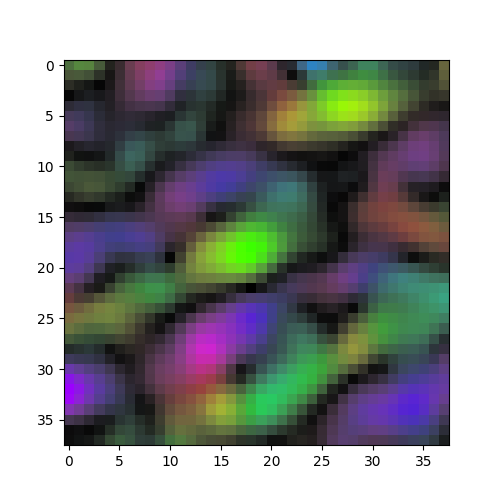

In [218]:
# imshow_vetor_field(tilt_center - np.array(zero_beam).reshape(2,1,1), rotation_angle=None, max_abs=4, pixel_size=pixel_size, show_arrow=False, arrow_scale=100)
# plt.savefig('tiltCenter-zeroBeam1.png', dpi=300, transparent=True)

# imshow_vetor_field(k_com - np.array(zero_beam).reshape(2,1,1), rotation_angle=None, max_abs=4, pixel_size=pixel_size, show_arrow=False, arrow_scale=100)
# plt.savefig('kCOM-zeroBeam1.png', dpi=300, transparent=True)

# imshow_vetor_field(k_com - tilt_center, rotation_angle=None, max_abs=4, pixel_size=pixel_size, show_arrow=False, arrow_scale=100)
# plt.savefig('kCOM-tiltCenter1.png', dpi=300, transparent=True)

imshow_vetor_field(diff, rotation_angle=180, max_abs=1, pixel_size=pixel_size, show_arrow=False, arrow_scale=100, filter=True, low_val=1.5, high_val=10)

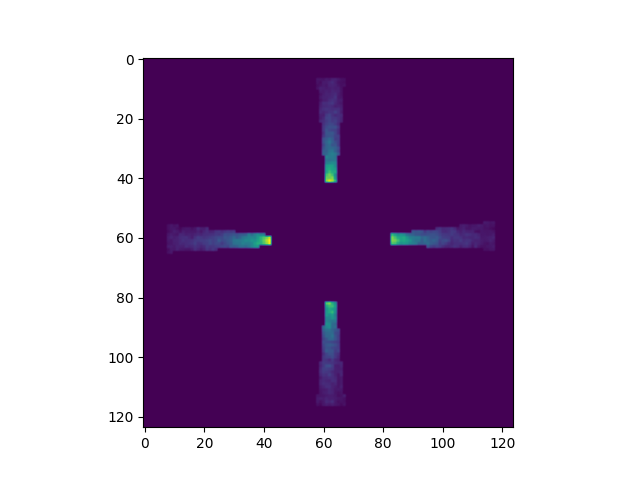

In [212]:
plt.figure()
plt.imshow(masked_k_data[1, 1, 1]+masked_k_data[1, 1, 0]+masked_k_data[1, 1, 2]+masked_k_data[1, 1, 3])

True


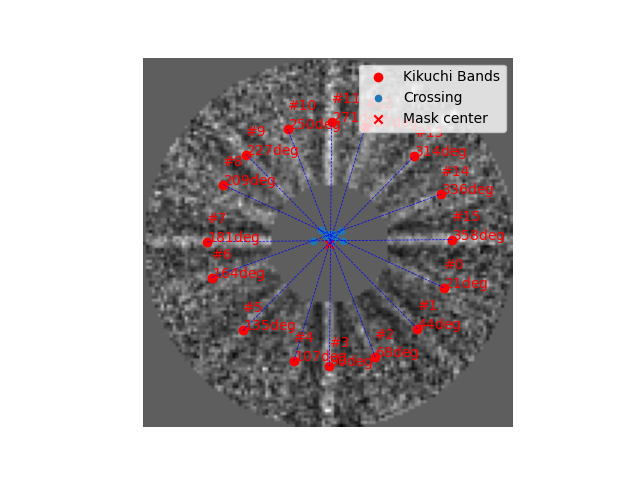

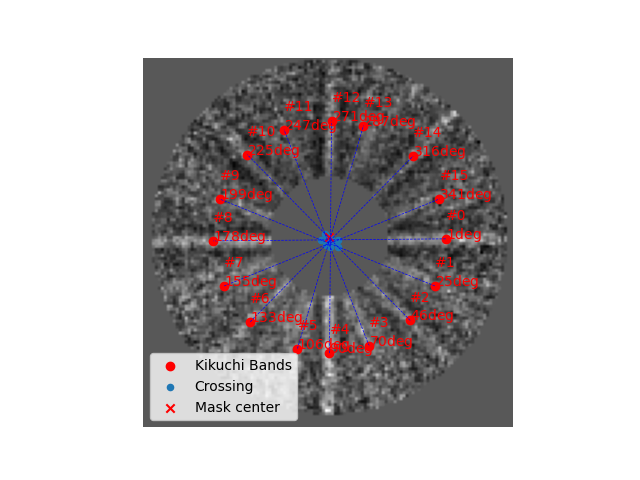

In [213]:
j= 10#np.random.randint(low=0, high=data4d.shape[0])
i= 10#np.random.randint(low=0, high=data4d.shape[1])

print(results[i,j]['converged'])
for res in results[i,j]['iterations']:
    plot_optimal_crossing(data4d[i,j], res, inner_radius=inner_radius)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def vector_to_rgb(angle, absolute):
    global max_abs
    angle = angle % (2 * np.pi)
    if angle < 0:
        angle += 2 * np.pi
    return matplotlib.colors.hsv_to_rgb((angle / (2 * np.pi), 
                                        absolute / max_abs, 
                                        absolute / max_abs))

os.chdir('/Users/menglin/Library/CloudStorage/OneDrive-MassachusettsInstituteofTechnology/MIT_Data/PMN/Experiments/250210_PMNPT/NBED/')
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('fitted_center.npy'):
            print(root)
            center = np.load(f'{root}/fitted_center.npy') - np.array(( 62.7615, 63.515,)).reshape(2, 1,1)
            imshow_vetor_field(center, rotation_angle=5, max_abs=10, pixel_size=1.985, show_arrow=False, arrow_scale=100)
 